In [1]:
using BenchmarkTools, Base.Test, PyPlot

# Problem 1: Exponential integrals

In this problem, you will write code to compute the [exponential integral](https://en.wikipedia.org/wiki/Exponential_integral) function
$$
E_1(z) = \int_z^\infty \frac{e^{-t}}{t} dt
$$
For simplicity, you only need to compute it for $\Re z \ge 0$, in which case the definition can be rewritten
$$
E_1(z) = \int_0^1 \frac{e^{-z/u}}{u} du
$$

## Slow version

This is the slow, simplistic implementation of this function, from the pset, that directly performs the integral numerically.  We will use it for comparisons:

In [2]:
function E₁_slow{T<:AbstractFloat}(z::Union{T,Complex{T}})
    real(z) < 0 && error("real(z) < 0 not implemented")
    return quadgk(u -> exp(-z/u)/u, 0, 1, reltol=eps(T)*10)[1]
end
E₁_slow{T<:Real}(z::Union{T,Complex{T}}) = E₁_slow(float(z))

E₁_slow (generic function with 2 methods)

To check this, a useful resource is [WolframAlpha](https://www.wolframalpha.com), which can compute $E_1(z)$ by `ExpIntegralE[1,z]`.  For $E_1(1.2)$, [we get](https://www.wolframalpha.com/input/?i=ExpIntegralE%5B1,1.2%5D) `0.158408436851462561424955970710861738534157976840578963378...`.  Compared to the above result, this corresponds to a relative error of:

In [3]:
# compute the relative error of approx compared to exact
relerr(approx,exact) = norm(approx - exact) / norm(exact)

relerr(E₁_slow(1.2), 0.158408436851462561424955970710861738534157976840578963378)

3.5043052210224057e-16

Hooray, we are getting the right result to nearly machine precision!  We can even do complex values this way:

In [4]:
relerr(E₁_slow(1.2 + 3.4im),
       -0.0196798781439709839467398951111963946354437628483798953 +
        0.0708764302707789307217865597073426047954413415009995511im)

1.886647948886305e-16

## Taylor series

The [Taylor series for E₁](http://functions.wolfram.com/GammaBetaErf/ExpIntegralE/06/01/04/01/02/) is:
$$
E_1(z) = -\log(z) - \gamma - \sum_{k=1}^\infty \frac{(-z)^k}{k!k}
$$
where $\gamma$ is the [Euler–Mascheroni constant](https://en.wikipedia.org/wiki/Euler%E2%80%93Mascheroni_constant) (`eulergamma` in Julia).

Let's write a function to compute this series until it converges (until the answer stops changing in the current precision), returning the answer and the number of terms required:  **Important:** when computing a series like this, it is important to realize that each term in the series can be *computed cheaply from the previous term*, rather than computing $z^k/k!$ separately for each term.

In [5]:
function E₁_taylor(z::Number)
    E₁ = -eulergamma - log(z)
    # iteratively compute the terms in the series, starting with k=1
    term = oftype(E₁, z) # use oftype to ensure type stability
    E₁ += term
    for k=2:1000000
        term = -term * z * (k-1) / (k * k)
        prev_E₁ = E₁
        E₁ += term
        E₁ == prev_E₁ && return (E₁, k-1)
    end
    return E₁, typemax(Int)
end

E₁_taylor (generic function with 1 method)

In [6]:
relerr(E₁_taylor(1.2)[1], 0.158408436851462561424955970710861738534157976840578963378)

3.5043052210224057e-16

In [7]:
relerr(E₁_taylor(1.2 + 3.4im)[1],
       -0.0196798781439709839467398951111963946354437628483798953 +
        0.0708764302707789307217865597073426047954413415009995511im)

3.3590811736585017e-15

Good, it seems to be giving the correct answer.  Now, let's make a plot of how many terms it is requiring to converge:

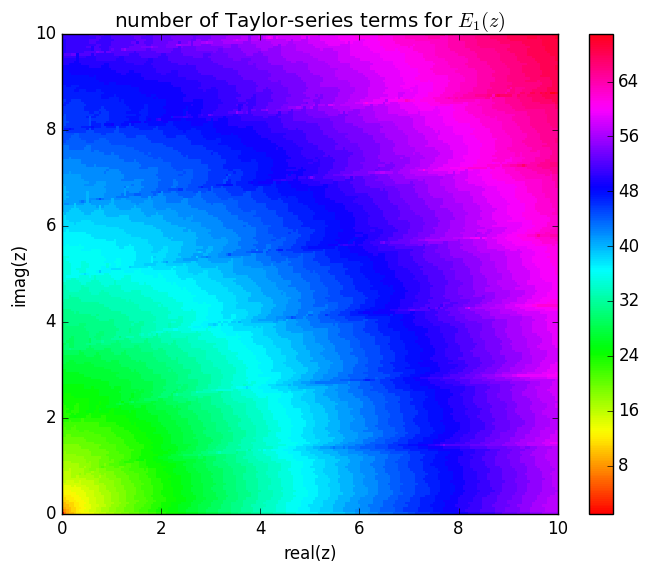

PyObject <matplotlib.text.Text object at 0x3270c6dd0>

In [8]:
x = linspace(0,10,200)
pcolor(x',x, [E₁_taylor(x+y*im)[2] for y in x, x in x], cmap="hsv")
colorbar()
xlabel("real(z)")
ylabel("imag(z)")
title(L"number of Taylor-series terms for $E_1(z)$")

Not surprisingly, it is good for small $|z|$ but starts to get big quickly.   For large $|z|$, we need a different algorithm, and for that we will use continued fractions.

For very small $|z|$, we will want to just inline the Taylor polynomial with `@evalpoly`, so let's close by writing a function that just computes the coefficients of the series (not including $\log(z)$):

In [9]:
# SOLUTION code
# n coefficients of the Taylor series of E₁(z) + log(z), in type T:
function E₁_taylor_coefficients{T<:Number}(::Type{T}, n::Integer)
    n < 0 && throw(ArgumentError("$n ≥ 0 is required"))
    n == 0 && return T[]
    n == 1 && return T[-eulergamma]
    # iteratively compute the terms in the series, starting with k=1
    term::T = 1
    terms = T[-eulergamma, term]
    for k=2:n
        term = -term * (k-1) / (k * k)
        push!(terms, term)
    end
    return terms
end

E₁_taylor_coefficients (generic function with 1 method)

In [10]:
E₁_taylor_coefficients(Float64, 10)

11-element Array{Float64,1}:
 -0.577216   
  1.0        
 -0.25       
  0.0555556  
 -0.0104167  
  0.00166667 
 -0.000231481
  2.83447e-5 
 -3.1002e-6  
  3.06192e-7 
 -2.75573e-8 

Let's write a macro that inlines this expression for a given number of terms and precision, which we'll use to do performance optimization below.  We will only do this `Float64` (double) precision, since that is the precision requested by the pset:

In [93]:
# SOLUTION code
macro E₁_taylor64(z, n::Integer)
    c = E₁_taylor_coefficients(Float64, n)
    taylor = Expr(:macrocall, Symbol("@evalpoly"), :t, c...)
    quote
        let t = $(esc(z))
            $taylor - log(t)
        end
    end
end

@E₁_taylor64 (macro with 1 method)

In [95]:
relerr(@E₁_taylor64(2.0, 30), E₁_taylor(2.0)[1])

2.837963777242665e-16

Good, seems to be computing the same thing.

## Continued-fraction expansion

The [continued-fraction expansion for E₁](http://functions.wolfram.com/GammaBetaErf/ExpIntegralE/10/) is:
$$
\frac{e^{-z}}{z + \frac{1}{1 + \frac{1}{z + \frac{2}{1 + \frac{2}{z + \frac{3}{1 + \cdots}}}}}}
$$

Of course, the exact continued-fraction expansion has an infinite number of terms.  If we truncate it to a finite number of terms, there is some ambiguity about what the last term should be (or the first term, since we iterate backwards through the coefficients).

People have investigated how to construct and define an *optimal* truncation for the continued-fraction expansion in some range of parameters, and the result is called a *modified approximant* [see e.g. equation (≈12) in Backeljaw and Cuyt, "Algorithm 895: A continued fractions package for special functions," *ACM TOMS* **36**, article 15 (2009)].

For E₁, I've played around a bit with this and ended up with a truncation that works pretty well:

In [13]:
# compute E₁ via n terms of the continued-fraction expansion, implemented
# in the simplest way:
function E₁_cf(z::Number, n::Integer)
    # starting with z seems to give many fewer terms for intermediate |z| ~ 3
    cf::typeof(inv(z)) = z
    for i = n:-1:1
        cf = z + (1+i)/cf
        cf = 1 + i/cf
    end
    return exp(-z) / (z + inv(cf))
end

E₁_cf (generic function with 1 method)

Let's check that this is converging for $z=4$:

In [14]:
[relerr(E₁_cf(4, n), E₁_slow(4)) for n in 1:20]

20-element Array{Float64,1}:
 0.00582285 
 0.000476212
 5.60469e-5 
 8.37068e-6 
 1.48464e-6 
 3.00369e-7 
 6.7499e-8  
 1.65353e-8 
 4.35523e-9 
 1.22051e-9 
 3.60936e-10
 1.11899e-10
 3.61737e-11
 1.21395e-11
 4.21339e-12
 1.50747e-12
 5.54472e-13
 2.09189e-13
 8.0784e-14 
 3.17858e-14

The continued-fraction expansion should converge more and more rapidly as $|z|$ gets large.  Let's try $z = 8$:

In [15]:
[relerr(E₁_cf(8, n), E₁_slow(8)) for n in 1:20]

20-element Array{Float64,1}:
 0.00162422 
 6.12415e-5 
 3.61306e-6 
 2.87668e-7 
 2.85331e-8 
 3.35576e-9 
 4.52707e-10
 6.84218e-11
 1.13852e-11
 2.05794e-12
 3.99931e-13
 8.29366e-14
 1.83504e-14
 4.31774e-15
 1.07943e-15
 3.59812e-16
 1.79906e-16
 1.79906e-16
 1.79906e-16
 1.79906e-16

Now, let's write a function to figure out how many terms we need in this expansion to converge to about 14 digits.  (We check convergence by comparing to the cf expansion with twice as many terms.)

In [27]:
function E₁_cf_nterms(z::Number, reltol=1e-14)
    for n = 1:100 # give up after 100 terms
        doubled = E₁_cf(z, 2n)
        if abs(E₁_cf(z, n) - doubled) ≤ reltol*abs(doubled)
            return n
        end
    end
    return 101
end

E₁_cf_nterms (generic function with 2 methods)

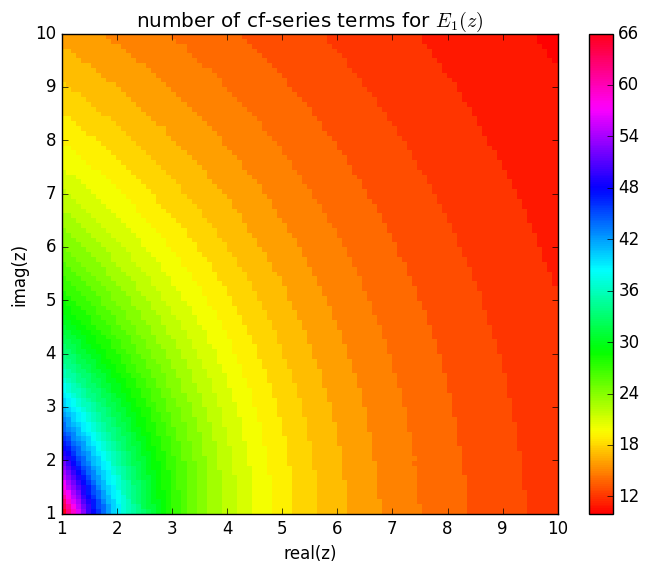

PyObject <matplotlib.text.Text object at 0x32e959d10>

In [28]:
x = linspace(1,10,100)
pcolor(x',x, [E₁_cf_nterms(x+y*im) for y in x, x in x], cmap="hsv")
colorbar()
xlabel("real(z)")
ylabel("imag(z)")
title(L"number of cf-series terms for $E_1(z)$")

Notice that the contours can be pretty well approximated by ellipses, similar to the Taylor series above.

Now, we'd like to figure out the crossover point where it becomes faster to compute a Taylor series than a continued-fraction expansion.  To do this, we need to first come up with a very efficient way to compute the continued-fraction expansion:

### Inlining the continued-fraction expansion for a fixed number of terms:

As in pset 2, we may want to inline this whole expansion for a fixed number of terms.  It is helpful to be able to look at the expansion, and we'll do this with SymPy as in pset 2:

In [18]:
using SymPy
display("text/latex", E₁_cf(Sym(:z), 4))

As in pset 2, we'll use the Polynomials package to write a macro that inlines this as a ratio of two polynomials.  (We can't exactly use the code from pset 2, since $z$ enters this expansion in a different way than in that pset, but the general idea is the same.)

As above, our macro will only work in double (`Float64`) precision.  We can compute the coefficients exactly as integers, but we need to use `BigInt` because otherwise they will quickly overflow.   We can't use `BigInt` coefficients in the macro, however, because then the resulting computation will be done in (slow!) arbitrary-precision arithmetic, so we convert the coefficients to `Float64`.

In [96]:
# SOLUTION code
# for numeric-literal coefficients: simplify to a ratio of two polynomials:
import Polynomials
# return (p,q): the polynomials p(x) / q(x) corresponding to E₁_cf(x, a...),
# but without the exp(-x) term
function E₁_cfpoly{T<:Real}(n::Integer, ::Type{T}=BigInt)
    q = Polynomials.Poly(T[1])
    p = x = Polynomials.Poly(T[0,1])
    for i = n:-1:1
        p, q = x*p+(1+i)*q, p # from cf = x + (1+i)/cf = x + (1+i)*q/p
        p, q = p + i*q, p     # from cf = 1 + i/cf = 1 + i*q/p
    end
    # do final 1/(x + inv(cf)) = 1/(x + q/p) = p/(x*p + q)
    return p, x*p + q
end
macro E₁_cf64(x, n::Integer)
    p,q = E₁_cfpoly(n, BigInt)
    evalpoly = Symbol("@evalpoly")
    num_expr = Expr(:macrocall, evalpoly, :t, Float64.(Polynomials.coeffs(p))...)
    den_expr = Expr(:macrocall, evalpoly, :t, Float64.(Polynomials.coeffs(q))...)
    quote
        let t = $(esc(x))
            exp(-t) * $num_expr / $den_expr
        end
    end
end

@E₁_cf64 (macro with 1 method)

Let's compare this to SymPy's result for simplifying the continued fraction to a ratio of polynomials, just to make sure we are getting the same polynomial:

In [20]:
display("text/latex", cancel(E₁_cf(Sym(:z), 4)))

In [21]:
E₁_cfpoly(4)

(Poly(250 + 314⋅x + 229⋅x^2 + 107⋅x^3 + 19⋅x^4 + x^5),Poly(120 + 480⋅x + 480⋅x^2 + 320⋅x^3 + 125⋅x^4 + 20⋅x^5 + x^6))

Yay!  Finally, these polynomials will be evaluated in the macro by Horner's rule or similar:

In [97]:
display("text/latex", @E₁_cf64 Sym(:z) 4)

Although the transformation of the continued fraction to a ratio of polynomials is exact in the absence of roundoff errors, we should double check that this hasn't accidentally created big rounding errors:

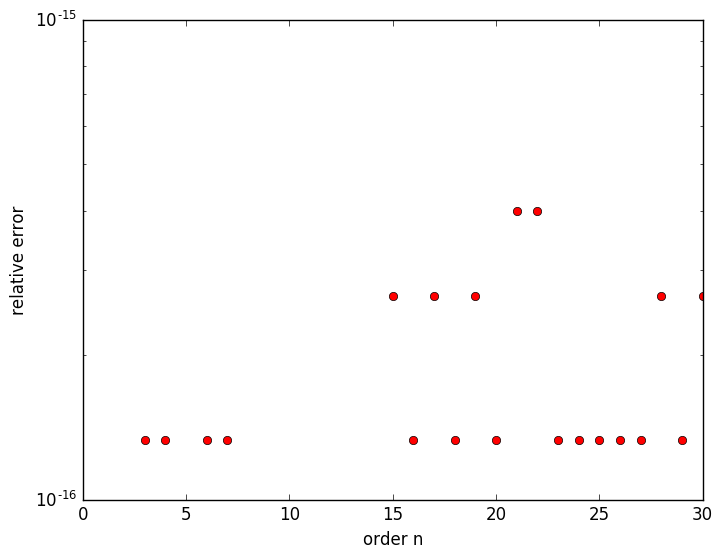

PyObject <matplotlib.text.Text object at 0x333cbbad0>

In [99]:
semilogy(0:30, [relerr(@eval(@E₁_cf64(3.0, $n)), E₁_cf(3.0, n)) for n in 0:30], "ro")
xlabel("order n")
ylabel("relative error")

Looks good!

## Taylor/continued-fraction crossover

Let's do some benchmarking to figure out (roughly) at what $|z|$ it becomes cheaper to use a hard-coded continued-fraction expansion than a hard-coded Taylor expansion:

In [29]:
function time_taylor(z)
    E₁, n = E₁_taylor(z)
    f = gensym() # generate a function name so that we can benchmark in a function
    @eval $f(z) = @E₁_taylor64 z $n
    b = @eval @benchmark $f($z)
    return time(minimum(b)) # time in ns
end
function time_cf(z)
    n = E₁_cf_nterms(z)
    f = gensym() # generate a function name so that we can benchmark in a function
    @eval $f(z) = @E₁_cf64 z $n
    b = @eval @benchmark $f($z)
    return time(minimum(b)) # time in ns
end

time_cf (generic function with 1 method)

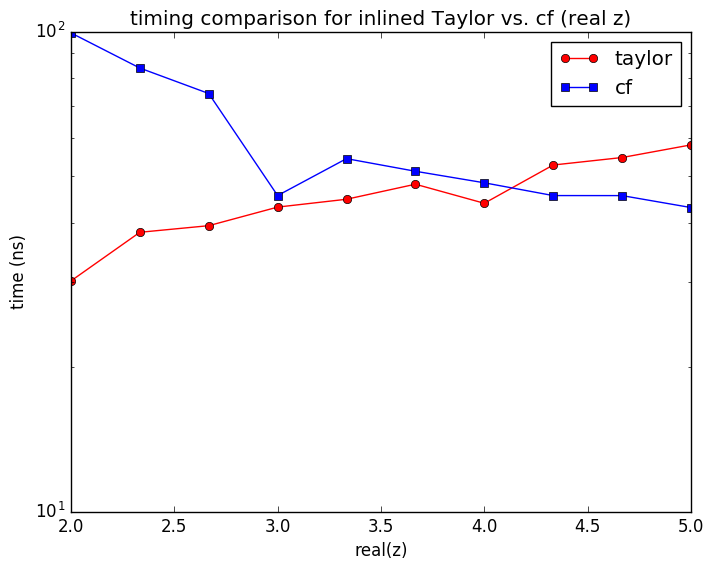

PyObject <matplotlib.text.Text object at 0x32f0ada10>

In [30]:
x = linspace(2,5, 10)
semilogy(x, [time_taylor(x) for x in x], "ro-")
semilogy(x, [time_cf(x) for x in x], "bs-")
xlabel("real(z)")
ylabel("time (ns)")
legend(["taylor", "cf"])
title("timing comparison for inlined Taylor vs. cf (real z)")

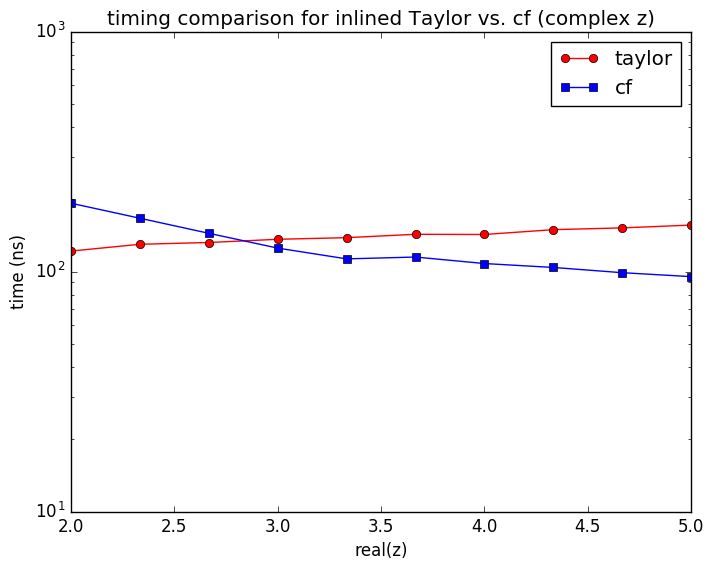

PyObject <matplotlib.text.Text object at 0x32f379490>

In [31]:
x = linspace(2,5, 10)
semilogy(x, [time_taylor(x + 0im) for x in x], "ro-")
semilogy(x, [time_cf(x + 0im) for x in x], "bs-")
xlabel("real(z)")
ylabel("time (ns)")
legend(["taylor", "cf"])
title("timing comparison for inlined Taylor vs. cf (complex z)")

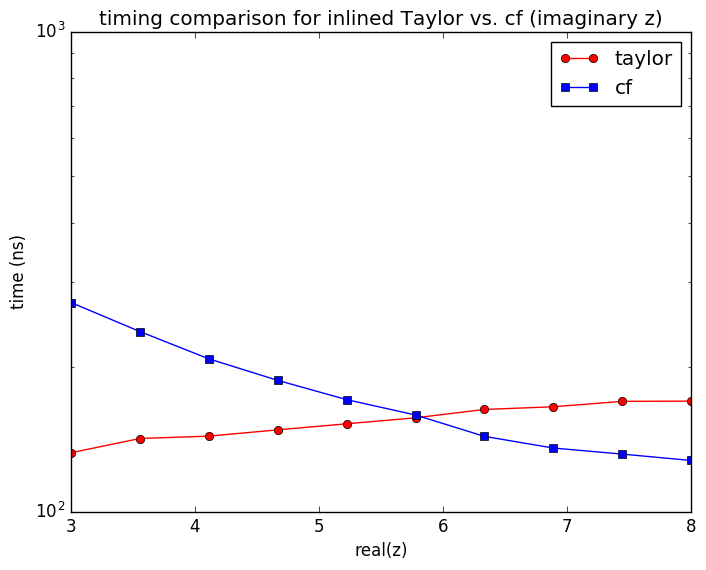

PyObject <matplotlib.text.Text object at 0x32f99f350>

In [32]:
x = linspace(3,8, 10)
semilogy(x, [time_taylor(x*im) for x in x], "ro-")
semilogy(x, [time_cf(x*im) for x in x], "bs-")
xlabel("real(z)")
ylabel("time (ns)")
legend(["taylor", "cf"])
title("timing comparison for inlined Taylor vs. cf (imaginary z)")

So, it looks like the inlined contined-fraction approach becomes better than Taylor at around $z \approx 3$ on the real-$z$ and about $z \approx 5$ on the imaginary-$z$ axis, where the number of terms in both the cf and Taylor expansions is about 30:

In [33]:
E₁_cf_nterms(3.0), E₁_cf_nterms(5.0im)

(26,33)

In [37]:
E₁_taylor(3.0)[2], E₁_taylor(5.0im)[2]

(28,35)

## Putting it all together

Let's put this all together into a single function that splits the (right-half) complex plane into different ellipses and uses hard-coded Taylor or continued-fraction expansions in each piece.

First, let's figure out the dividing lines along the real and imaginary axes to use continued-fraction expansions with 30, 15, 8, and 4 terms:

In [118]:
x = 1:0.2:1000
cf_cutoffs = hcat([ x[findfirst(x -> E₁_cf_nterms(x) < n, x)] for n in (30,15,8,4) ],
                  [ x[findfirst(x -> E₁_cf_nterms(x*im) < n, x)] for n in (30,15,8,4) ])

4×2 Array{Float64,2}:
   2.8    5.8
   7.6   12.0
  23.2   28.8
 199.0  203.6

If we approximate the cutoff in the complex plane $z=x + iy$ by an ellipse, then we want an equation $x^2 + ay^2 ≥ b^2$, where $a$ and $b$ are given by:

In [43]:
hcat( (cf_cutoffs[:,1]./cf_cutoffs[:,2]).^2, cf_cutoffs[:,1].^2 )

4×2 Array{Float64,2}:
 0.233056      7.84
 0.401111     57.76
 0.64892     538.24
 0.955324  39601.0 

Similarly for the Taylor expansion, except that here we need to look for very small $x$, and we want the *largest* $x$ rather than the smallest:

In [121]:
x = logspace(-8,1,10000)
taylor_cutoffs = hcat([ x[findlast(x -> E₁_taylor(x)[2] < n, x)] for n in (30,15,8,4) ],
                      [ x[findlast(x -> E₁_taylor(x*im)[2] < n, x)] for n in (30,15,8,4) ])

4×2 Array{Float64,2}:
 3.36863     3.52578   
 0.605589    0.633841  
 0.0539229   0.0539229 
 0.00045401  0.00045401

In [65]:
hcat( (taylor_cutoffs[:,1]./taylor_cutoffs[:,2]).^2, taylor_cutoffs[:,1].^2 )

4×2 Array{Float64,2}:
 0.912843  11.3476    
 0.912843   0.366738  
 1.0        0.00290768
 1.0        2.06125e-7

However, this is not quite good enough along the imaginary axis: 30 terms in the Taylor series is fine up to $\Im z ≤ 3.53$, but 30 terms in the cf expansion was good for $\Im z ≥ 5.8$.  We need to figure out how many terms in the Taylor series we need to go up to $\Im z ≤ 5.8$:

In [124]:
E₁_taylor(5.8*im)[2]

37

Also, for large enough $\Re z$, the E₁ function will **underflow**: give 0.0 because the result is smaller than the minimum representable floating-point number.  This will happen quite quickly for large $\Re z$ because of the $e^{-z}$ dependence.  Let's find out when this occurs on the real axis:

In [54]:
x = linspace(1,2000,10000)
x[findfirst(x -> E₁_cf(x,0) == 0.0, x)]

738.7047704770478

In [61]:
E₁_cf(739 - 4im,0)

-0.0 - 0.0im

In [60]:
739^2

546121

Finally, we'll hard-code our double-precision E₁ function using these dividing points, assuming that they describe the semi-axes of ellipses in the complex $z$ plane (as seems to be the case from our numerical experiments above):

In [134]:
# SOLUTION:
function E₁(z::Union{Float64,Complex{Float64}})
    x² = real(z)^2
    y² = imag(z)^2
    if x² + 0.233*y² ≥ 7.84 # use cf expansion, ≤ 30 terms
        if (x² ≥ 546121) & (real(z) > 0) # underflow
            return zero(z)
        elseif x² + 0.401*y² ≥ 58.0 # ≤ 15 terms
            if x² + 0.649*y² ≥ 540.0 # ≤ 8 terms
                x² + y² ≥ 4e4 && return @E₁_cf z 4
                return @E₁_cf64 z 8
            end
            return @E₁_cf64 z 15
        end
        return @E₁_cf64 z 30
    else # use Taylor expansion, ≤ 37 terms
        r² = x² + y²
        return r² ≤ 0.36 ? (r² ≤ 2.8e-3 ? (r² ≤ 2e-7 ? @E₁_taylor64(z,4) :
                                                       @E₁_taylor64(z,8)) :
                                         @E₁_taylor64(z,15)) :
                          @E₁_taylor64(z,37)
    end
end
E₁{T<:Integer}(z::Union{T,Complex{T},Rational{T},Complex{Rational{T}}}) = E₁(float(z))

E₁ (generic function with 2 methods)

For accuracy-testing purposes, let's compare it to a function that uses 50 terms in Taylor or cf:

In [122]:
E₁_test(z::Union{Float64,Complex{Float64}}) =
    real(z)^2 + imag(z)^2 > 6 ? E₁_cf(z,100) : E₁_taylor(z)[1]

E₁_test (generic function with 1 method)

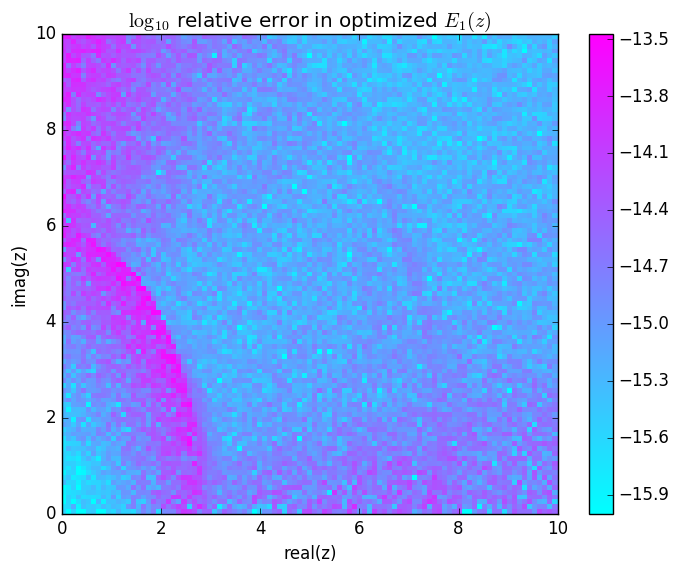

PyObject <matplotlib.text.Text object at 0x338b1aa10>

In [130]:
x = linspace(1e-10,10,100)
pcolor(x',x, [log10(1e-16 + relerr(E₁(x+y*im),E₁_test(x+y*im))) for y in x, x in x], cmap="cool")
colorbar()
xlabel("real(z)")
ylabel("imag(z)")
title(L"$\log_{10}$ relative error in optimized $E_1(z)$")

It seems to be achieving the required 13 digits of accuracy specified in the pset.  However, if we were really serious about this, we should probably look at alternative expansions to get better accuracy in the purple regions of the plot above.  (The simplest thing might be to do a Taylor expansion around, say, $z=2+4i$.  There are also alternative forms of the continued-fraction expansion and other identities that we could try to exploit.)

Now let's compare performance at a few points versus our original `quadgk` implementation:

In [135]:
@btime E₁(2+2im)
@btime E₁_slow(2+2im)

  193.599 ns (1 allocation: 32 bytes)
  44.889 μs (425 allocations: 10.55 KiB)


-0.033767089606562 - 0.01859941416975054im

In [136]:
@btime E₁(10+2im)
@btime E₁_slow(10+2im)

  139.873 ns (1 allocation: 32 bytes)
  18.827 μs (183 allocations: 4.61 KiB)


-2.3461694530923403e-6 - 3.347026042268865e-6im

In [137]:
@btime E₁(5)
@btime E₁_slow(5)

  109.531 ns (1 allocation: 16 bytes)
  8.282 μs (159 allocations: 3.45 KiB)


0.001148295591275326

This is **almost a factor of 100 speedup** even in cases where the expansion requires a lot of terms, which seems pretty good.

It would be good to also compare to a highly optimized implementation, e.g. the [exp1 function in SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.exp1.html).  Because that is a Python function, we need to benchmark it for a whole array of numbers in order to make a reasonable comparison:

In [138]:
using PyCall
exp1 = pyimport_conda("scipy.special", "scipy")["exp1"]

PyObject <ufunc 'exp1'>

In [139]:
relerr(E₁(2+2im), exp1(2+2im))

5.75981106819841e-15

In [142]:
z = rand(10^6)*10 + rand(10^6)*10im
@btime pycall($exp1, PyObject, $(PyObject(z))) evals=1;

  1.282 s (12 allocations: 400 bytes)


In [143]:
E₁(z::AbstractVector) = map(E₁, z)
@btime E₁($z) evals=1;

  209.063 ms (1000005 allocations: 45.78 MiB)


What about for real arguments?

In [145]:
@btime pycall($exp1, PyObject, $(PyObject(real(z)))) evals=1;
@btime E₁($(real(z))) evals=1;

  503.554 ms (12 allocations: 400 bytes)
  102.485 ms (1000005 allocations: 22.89 MiB)


Pretty good!  We are **6 times faster** than the SciPy routine for complex arguments, and **5 times faster** for real arguments, even though SciPy internally calls an optimized Fortran routine.

It's actually not unusual for special functions written in Julia to beat older optimized C and Fortran implementations.  We've observed this for the [erfinv](https://github.com/JuliaLang/julia/pull/2987) and [polygamma](https://github.com/JuliaLang/julia/pull/7125) functions, for example.   The reason is that the inlining performed by macros like `@evalpoly` and `@E₁_cf64` is hard to replicate in lower-level languages — hardly anyone bothers to write the code-generation programs that would be required — but it is fairly easy in Julia.

# Problem 2: Parallel mapreduce

Our task is to speed up the function `myreduce(⊕, n)` that computes
$$
    1 \oplus 2 \oplus 3 \oplus \cdots \oplus n
$$
for $n \ge 0$, where $\oplus$ is a caller-supplied **commutative binary function** `⊕(x,y)`, and we are allowed to assume commutativity.  

A simple parallel solution for this is similar to the `pmap` function described in the [Julia manual](http://docs.julialang.org/en/stable/manual/parallel-computing/): we just ask the worker processes to "add" (`⊕`) terms one by one, giving it another term to add as soon as the worker becomes idle.

In [164]:
function preduce(⊕, lst::AbstractVector)
    if nprocs() == 1
        return reduce(⊕, lst)
    end
    n = length(lst)
    queue = Base.copymutable(lst)
    @sync begin
        for p in workers()
            @async begin
                while length(queue) > 1
                    a = pop!(queue)
                    b = pop!(queue)
                    # compute results[p] = results[p] ⊕ lst[idx]
                    push!(queue, remotecall_fetch(⊕, p, a, b))
                end
            end
        end
    end
    if isempty(queue)
        return ⊕() # return empty call if it is defined
    else
        assert(length(queue) == 1)
        return queue[1]
    end
end
preduce(⊕, n::Integer) = preduce(⊕, 1:n)

preduce (generic function with 2 methods)

In [150]:
preduce(+, 1000) == 500500

true

In [171]:
function weirdplus(x,y)
    sleep(1e-3 / (x+y)) # wait for some number of seconds
    return x + y
end
preduce(weirdplus, 1000)

500500

Now, let's check how well this paralellizes:

In [172]:
@btime preduce(weirdplus, 1000) evals=1

  1.376 s (6065 allocations: 377.69 KiB)


500500

In [175]:
addprocs(4) # parallelize over 4 workers
workers()

4-element Array{Int64,1}:
 14
 15
 16
 17

In [177]:
@everywhere function weirdplus(x,y)
    sleep(1e-3 / (x+y)) # wait for some number of seconds
    return x + y
end
@btime preduce(weirdplus, 1000) evals=1

  434.293 ms (92426 allocations: 3.76 MiB)


500500

In [178]:
1.376 / 0.434293

3.1683678990911663

Not terrible, a 3x speedup.

One limitation of the `preduce` solution above is that it assumes that evaluations of `⊕` are **individually quite expensive**, so that the overhead of one `remotecall_fetch` per call to `⊕` is not important.

If `⊕` were a very cheap function, like `+`, this would be terrible!  There are various approaches that we could pursue to improve this, like iteratively doubling the number of elements that are sent to the workers until the time per `remotecall_fetch` exceeds some threshold, but I won't attempt to implement them here.